---
layout: post
title:  "Plotting US COVID-19 Incidence"
desc: "A quick redesign of an incidence reporting plot"
date: ###DATE
categories: [tutorial]
tags: [plotting]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/uscovid"

---

One of my favourite subreddits is [/r/dataisbeautiful](https://reddit.com/r/dataisbeautiful/top). Today I saw a [plot from that sub that was, on first glimpse, beautiful](https://www.reddit.com/r/dataisbeautiful/comments/hkvb3r/oc_7day_rolling_average_of_positive_covid19_test/)! And full credit to the author for getting the data and presenting it beautifully. However, I had some small issues with it. The first was that it was smoothing over a cumulative window (instead of showing what I think people expect, which is how many people caught COVID-19 on those dates). The second was the colour scheme was diverging despite the data being sequential. No doubt it looks so good because of this colour scheme, but those two issues made the plot quite hard for me to extract information from.

So I decided to make an admittedly not-as-good-looking plot, but hopefully one that's easier to digest accurately. Remember, for plotting, function comes first. Always.

Here's what we'll be making:

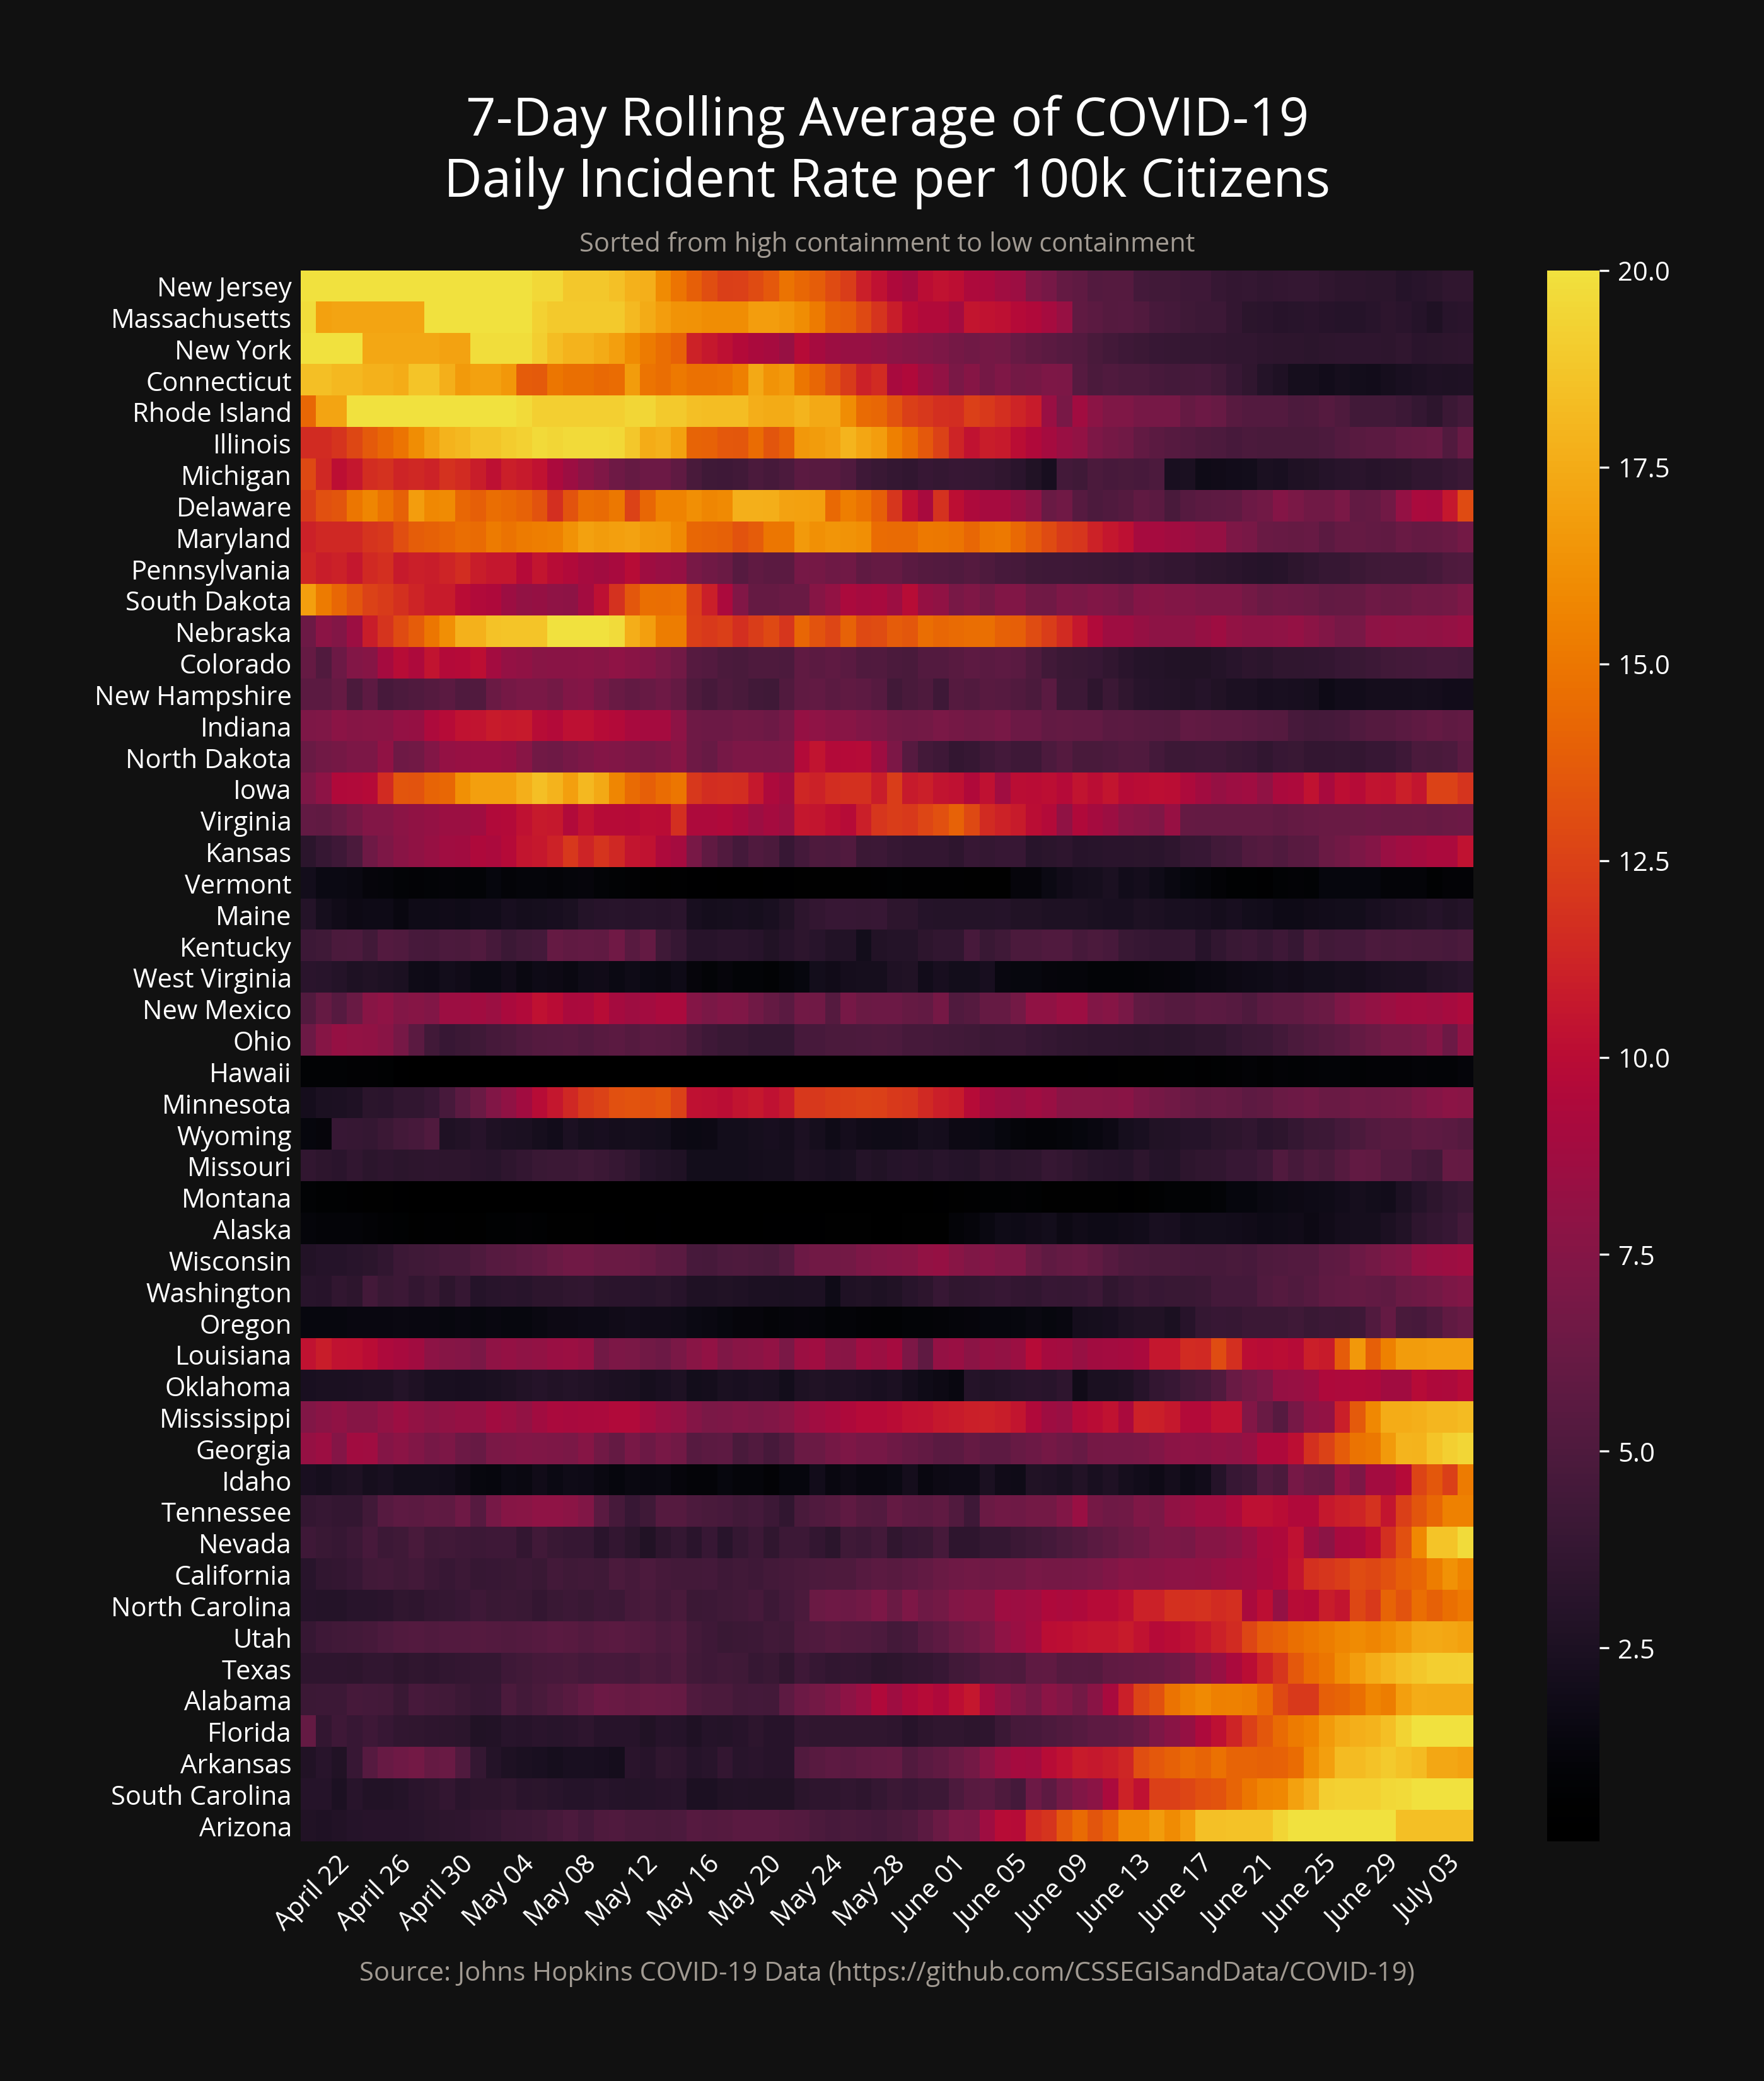

In [1]:
from IPython.display import Image
Image("us_covid_growth/covid19.png")

!!! img-poster img-lighten


To start, I cloned down the Johns Hopkins COVID-19 repo, and initally set the same states to exclude as the original post (which has [source code here](https://github.com/DavidMorton/COVID-19-Analysis/blob/master/COVID-19%20Confirmed%20Percentage%20Heatmap.ipynb)).

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cmasher as cmr

# Some config variables that Im going to break scope with, forgive me.

# Dir where you clone out https://github.com/CSSEGISandData/COVID-19
data_directory = "D:/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/"
states_to_drop = ['Puerto Rico', 'American Samoa', 'Guam', 'District of Columbia', 
                  'Diamond Princess', 'Northern Mariana Islands', 'Virgin Islands',
                 'Recovered', "Grand Princess"]
columns_to_keep = ["Province_State", "Incident_Rate"]

Then, lets find all the csv files for the US states and load them in.

In [2]:
def load_csv(directory, filename):
    date = filename.replace(".csv", "")
    df = pd.read_csv(os.path.join(directory, filename))[columns_to_keep]
    df["date"] = pd.to_datetime(date, format="%m-%d-%Y")
    return df

def load_data(directory):
    files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    dataframes = [load_csv(directory, f) for f in files]
    df_all = pd.concat(dataframes)
    df_all = df_all.rename(columns={"Province_State": "state", 
                                    "Incident_Rate": "rate"})
    return df_all[~df_all.state.isin(states_to_drop)]

# Load all the data into long format
df_long = load_data(data_directory)

We now have the cumulative number of cases per 100k residents for each state.

With the long format data attained, we now pivot to separate state and date, and then sort the columns. 

As the incident rate is cumulative, we take the difference to the previous day, dropping day 0.

In [3]:
# Pivot into a 2D format and sort the columns
df_wide = df_long.pivot(index="date", columns="state", values="rate")

In [5]:
# Take the difference to get the change in incidence. 
# Drop the first row as its all NaN
df_diff = df_wide.diff().iloc[1:, :]

# There seems to be some odd spikes in the data. 
# In fact, from look at each state individually,
# this data is definitely incorrect in some way. 
# Many states have a drop by 20 to 60% in the number
# of accumulated cases at the start of May... 
# For now, Ill just clip the data
df_diff = df_diff.clip(0, 20)

For this to look good, we want some smart sorting of the columns. Lets determine a linear slope from the incidence rate difference and sort by that.

In [6]:
day_of_year = df_diff.index.dayofyear.to_numpy()
day_weight = day_of_year - day_of_year.mean()
sort_weight = (df_diff.T * day_weight).sum(axis=1)

In [7]:
df_sorted = df_diff.iloc[:, sort_weight.argsort()].T

Finally, let us plot everything nicely, and add an option to add some mean smoothing into the data.

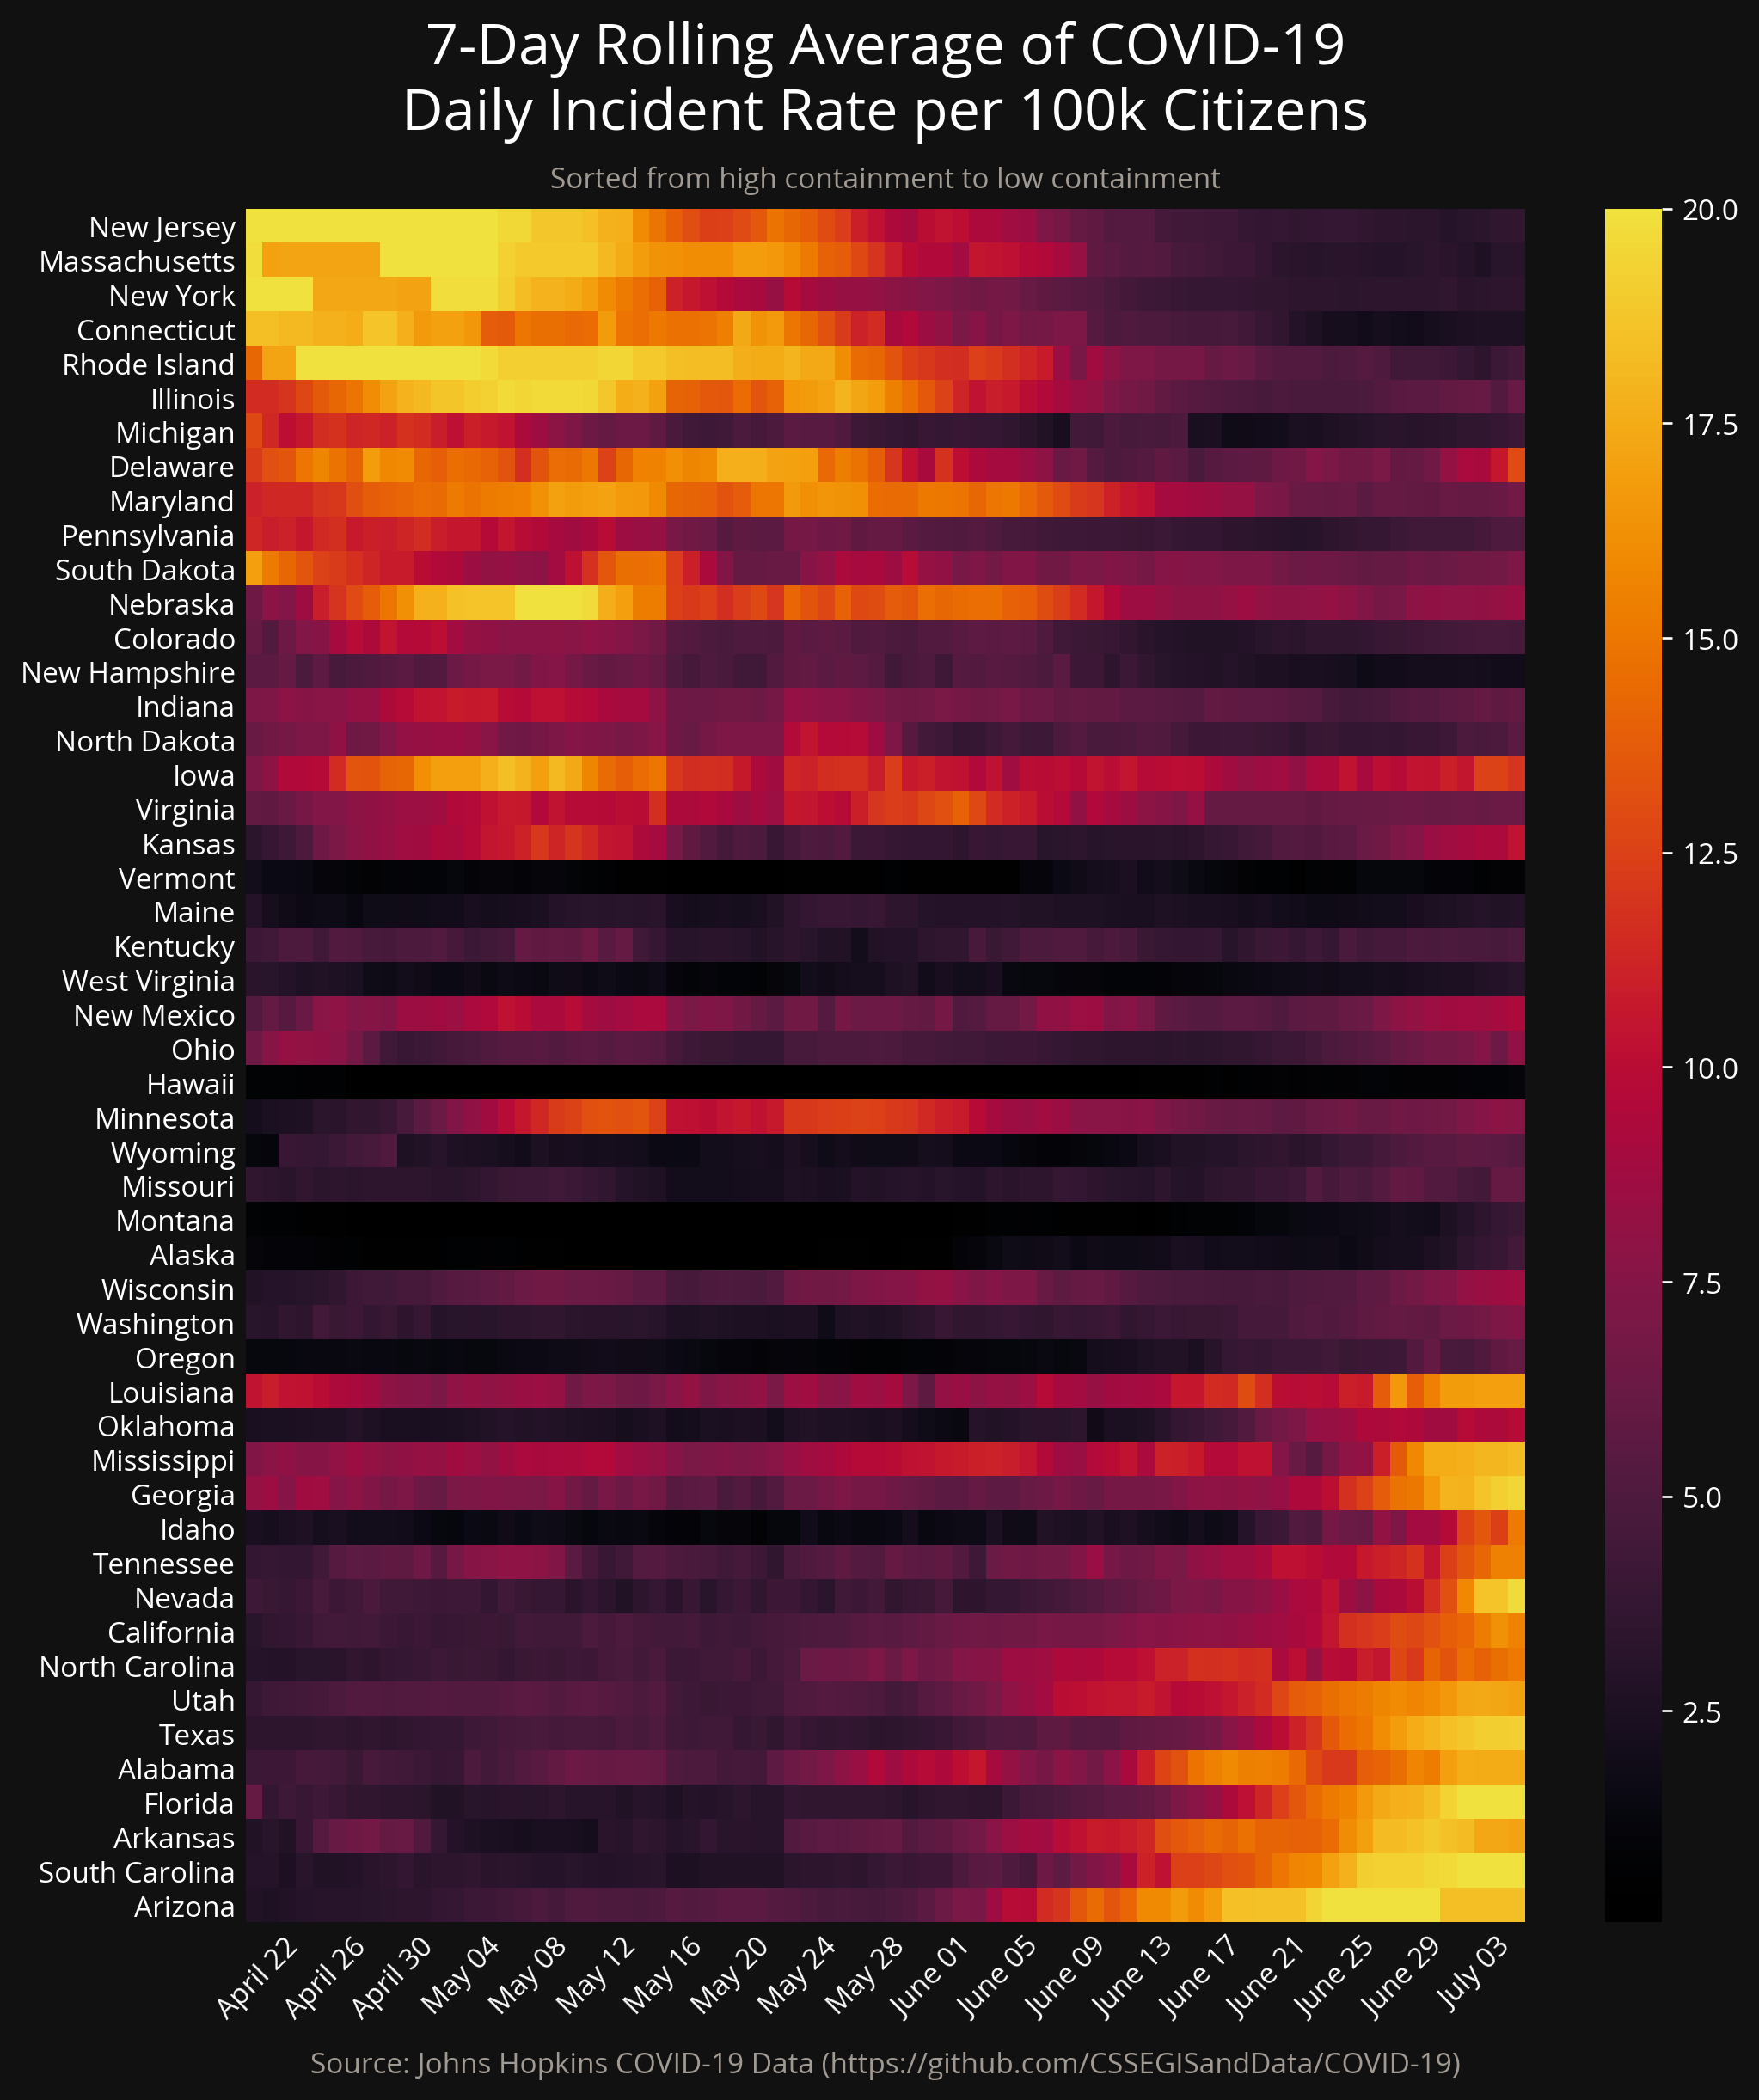

In [8]:
def plot_evolution(dfo, smooth=7, cmap=None):
    # Optionally smooth the data
    df = dfo.rolling(smooth, axis=1).mean().iloc[:, smooth - 1:] if smooth else dfo
        
    if cmap is None: # Default to using cmasher's ember colorscale. Thanks Ellert.
        cmap = plt.get_cmap('cmr.ember') 
    
    # Set up plotting style with dark bg
    with plt.style.context("dark_background"):
        fig, ax = plt.subplots(figsize=(10, 11))
        idx = [d.strftime("%B %d") for d in df.columns]
        xlabels = [x if i % 4 == 3 else "" for i, x in enumerate(idx)]
        sns.heatmap(df, ax=ax, cmap=cmap, xticklabels=xlabels, cbar_kws={"aspect": 30})
        ax.set_xticklabels(labels=xlabels, rotation=45, ha="right")
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xlabel('')
        ax.set_ylabel('')
        fig.patch.set_facecolor('#111111')
        ax.set_title('7-Day Rolling Average of COVID-19\nDaily Incident Rate per 100k Citizens\n', 
                     size=20, pad=5)
        ax.annotate('Source: Johns Hopkins COVID-19 Data (https://github.com/CSSEGISandData/COVID-19)', 
                    (0.5,0), (0, -45), xycoords='axes fraction', color="#a19a92",
                    textcoords='offset points', size=10, va='top', ha="center")
        ax.annotate('Sorted from high containment to low containment', 
                    (0.5,1), (0, 15), xycoords='axes fraction', color="#a19a92",
                    textcoords='offset points', size=10, va='top', ha="center")
        fig.savefig("covid19.png", dpi=300, bbox_inches="tight", pad_inches=0.5, 
                    facecolor=fig.get_facecolor())

plot_evolution(df_sorted)

!!! poster

And there we have it. Not as beautiful as the original, but hopefully a better representation of the data. I also talk about this in the comments, but there really does seem to be an awful artifact in the data for almost all states in the month of May, where the **cumulative** incident rate drops. Which is, you know, impossible. But without the sources, I don't know what is going on here.

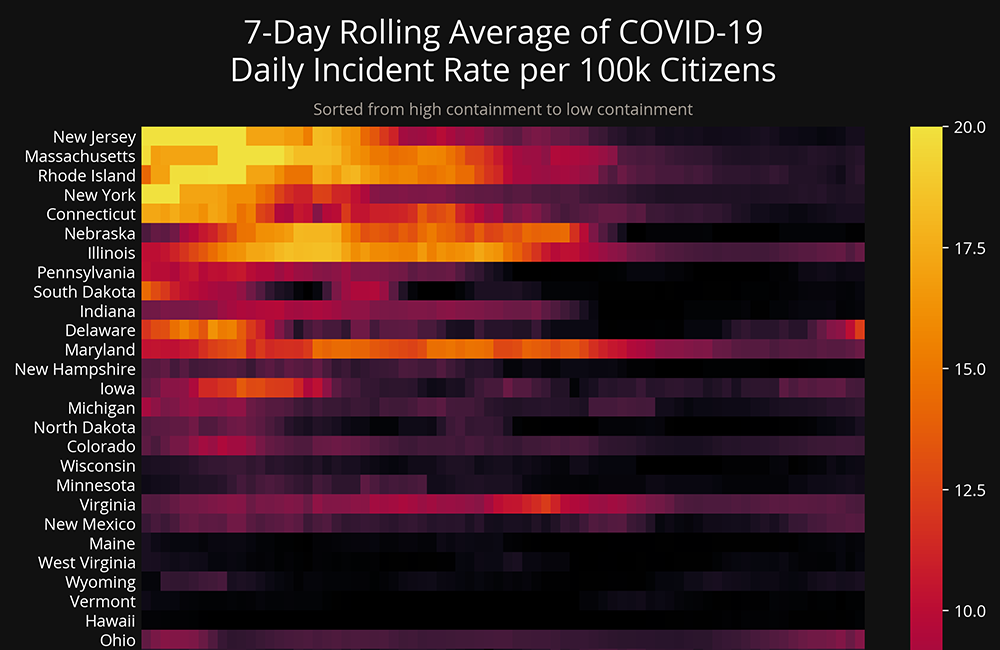

In [9]:
from IPython.display import Image
Image("us_covid_growth/cover.png")

!!!main remove_main